In [34]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
import hvplot
import hvplot.pandas
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

# Dataframe Development and creation of trade signals

In [35]:
stock = 'MSFT'
df = yf.download(stock,'2010-12-01', '2020-12-02')

df['Daily Returns'] = df['Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower
Date,,,,,,,,,,
2010-12-01,25.570000,26.250000,25.559999,26.040001,20.703621,74123500,NaN,NaN,NaN,NaN
2010-12-02,26.240000,26.980000,26.200001,26.889999,21.379427,91759200,0.032642,NaN,NaN,NaN
2010-12-03,26.809999,27.059999,26.780001,27.020000,21.482788,52622000,0.004835,NaN,NaN,NaN
2010-12-06,26.930000,26.980000,26.760000,26.840000,21.339668,36264200,-0.006662,NaN,NaN,NaN
2010-12-07,27.080000,27.129999,26.850000,26.870001,21.363522,57860500,0.001118,NaN,NaN,NaN


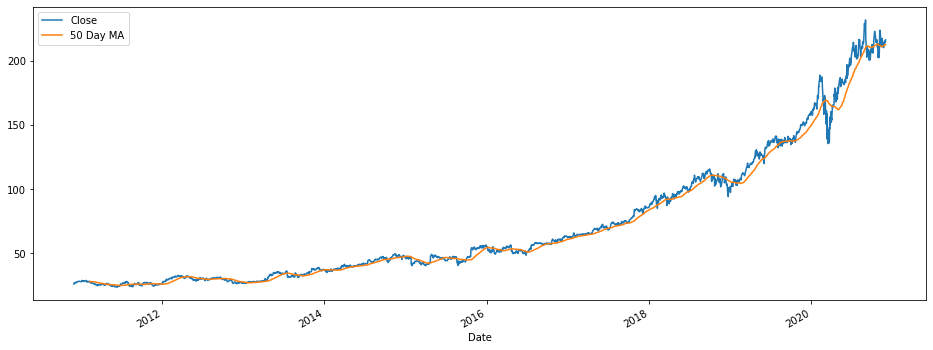

In [36]:
# Bolllinger Analysis Bands

#Close 50 MA

df['50 Day MA'] = df['Close'].rolling(window = 50).mean()

#Upper = 50 MA + 2*std(50 days)

df['Upper'] = df['Close'] + 2*(df['Close'].rolling(50).std())

#Lower = 50 MA - 2*std(50 days)

df['Lower'] = df['50 Day MA'] - 2*(df['Close'].rolling(50).std())

#Plot the Data

df[['Close','50 Day MA']].plot(figsize = (16,6))

df.head()

In [37]:
# New Trading Signals

# Buy when Close price is higher than the upper band, Sell when it is the lower than the lower band, Hold when it is between

# 1.0 -- Buy
# 0.0 -- Sell

df['Trading Signal'] = np.where(df['Close'] < df['50 Day MA'], 1.0,
                        (np.where(df['Close'] > df['50 Day MA'], 0.0,
                                  np.where(df['Close'] != 0.0 , 0.0, 1.0))))

# Calculate the points in time at which a position should be taken, 1 or -1

df['Entry/Exit'] = df['Trading Signal'].diff()

df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
Date,,,,,,,,,,,,
2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [38]:
# X is the input variable

X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '50 Day MA', 'Upper', 'Lower']]

# Y is the target

y = df[['Entry/Exit']]

In [39]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=78)

In [40]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [41]:

rf_model  = RandomForestClassifier(random_state=5)

In [42]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [43]:
predictions = rf_model.predict(X_test_scaled)

In [44]:
# Calculating the confusion matrix

cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual Sell", "Actual Hold", "Actual Buy"], columns=["Predicted Sell", "Predicted Hold", "Predicted Buy"]
)


In [45]:
# Calculating the accuracy score

acc_score = accuracy_score(y_test, predictions)

In [46]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted Sell,Predicted Hold,Predicted Buy
Actual Sell,2,21,0
Actual Hold,2,684,1
Actual Buy,2,28,1


Accuracy Score : 0.9271255060728745
Classification Report
              precision    recall  f1-score   support

        -1.0       0.33      0.09      0.14        23
         0.0       0.93      1.00      0.96       687
         1.0       0.50      0.03      0.06        31

    accuracy                           0.93       741
   macro avg       0.59      0.37      0.39       741
weighted avg       0.90      0.93      0.90       741



In [47]:
#df.to_csv('MSFT_df.csv', index = True)

In [48]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
Date,,,,,,,,,,,,
2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


# Ensemble Learning Gradient boosting

In [49]:
file_path = Path("MSFT_df.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
0,2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
1,2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2,2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
3,2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
4,2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [50]:
# X is the input variable

X = df[['Open', 'High', 'Low', 'Close']]

# Y is the target

y = df[['Entry/Exit']].values.reshape(-1, 1)

In [51]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=78)

In [52]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [53]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [54]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [55]:
 # Choose learning rate
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=learning_rate,
        max_features=2,
        max_depth=3,
        random_state=0)
    model.fit(X_train_scaled,y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.961
Accuracy score (validation): 0.913

Learning rate:  0.1
Accuracy score (training): 0.988
Accuracy score (validation): 0.910

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.891

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.888

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.883

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.881



In [56]:
# Create GradientBoostingClassifier model
model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=1,
    max_features=4,
    max_depth=3,
    random_state=0)

# Fit the model
model.fit(X_train_scaled,y_train.ravel())

# Score the model
print("Accuracy score (training): {0:.3f}".format(
    model.score(
        X_train_scaled,
        y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    model.score(
        X_test_scaled,
        y_test)))

Accuracy score (training): 1.000
Accuracy score (validation): 0.885


In [57]:
# Make predictions
predictions = model.predict(X_test_scaled)

# Generate accuracy score for predictions using y_test
accuracy_score(y_test, predictions)

0.8849045691150954

In [58]:
# Calculating the confusion matrix

cm = confusion_matrix(y_test, predictions)


cm_df = pd.DataFrame(
    cm, index=["Actual Sell", "Actual Hold", "Actual Buy"], columns=["Predicted Sell", "Predicted Hold", "Predicted Buy"]
)



In [59]:
# Generate classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        -1.0       0.16      0.10      0.12        71
         0.0       0.92      0.95      0.94      1588
         1.0       0.17      0.11      0.14        70

    accuracy                           0.88      1729
   macro avg       0.42      0.39      0.40      1729
weighted avg       0.86      0.88      0.87      1729



In [60]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted Sell,Predicted Hold,Predicted Buy
Actual Sell,7,63,1
Actual Hold,34,1515,39
Actual Buy,2,60,8


Accuracy Score : 0.9271255060728745
Classification Report
              precision    recall  f1-score   support

        -1.0       0.16      0.10      0.12        71
         0.0       0.92      0.95      0.94      1588
         1.0       0.17      0.11      0.14        70

    accuracy                           0.88      1729
   macro avg       0.42      0.39      0.40      1729
weighted avg       0.86      0.88      0.87      1729



# LSTM RNN

In [61]:
# Importing the training set
df = pd.read_csv('MSFT_df.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
0,2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
1,2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2,2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
3,2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
4,2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [67]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [68]:
# Predict Closing Prices using a 60 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 4
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)


In [69]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [70]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [71]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))


# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [73]:
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
54/54 [==============================] - 1s 24ms/step - loss: 0.0020
Epoch 2/100
54/54 [==============================] - 2s 29ms/step - loss: 2.0028e-04
Epoch 3/100
54/54 [==============================] - 1s 25ms/step - loss: 1.9033e-04
Epoch 4/100
54/54 [==============================] - 1s 27ms/step - loss: 1.9403e-04
Epoch 5/100
54/54 [==============================] - 1s 25ms/step - loss: 1.6946e-04
Epoch 6/100
54/54 [==============================] - 1s 26ms/step - loss: 1.5460e-04
Epoch 7/100
54/54 [==============================] - 1s 27ms/step - loss: 1.6413e-04
Epoch 8/100
54/54 [==============================] - 2s 29ms/step - loss: 1.6362e-04
Epoch 9/100
54/54 [==============================] - 1s 27ms/step - loss: 1.3722e-04
Epoch 10/100
54/54 [==============================] - 1s 27ms/step - loss: 1.2406e-04
Epoch 11/100
54/54 [==============================] - 1s 26ms/step - loss: 1.3662e-04
Epoch 12/100
54/54 [==============================] - 8s 146ms/step

In [74]:
# Evaluate the model
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 7ms/step - loss: 0.0020


0.002039512852206826

In [75]:
predicted = model.predict(X_test)

In [76]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [77]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
1731,85.400002,85.889709
1732,85.709999,85.799858
1733,85.720001,85.739464
1734,85.540001,85.722946
1735,85.949997,85.721825


In [78]:
# Plot the real vs predicted values as a line chart
stocks.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# LSTM CNN

In [79]:
# Importing the training set
df = pd.read_csv('MSFT_df.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
0,2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
1,2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2,2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
3,2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
4,2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [80]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [81]:
# Predict Closing Prices using a 60 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10


feature_column = 4 #Close
target_column = 4 #Close
X, y = window_data(df, window_size, feature_column, target_column)

In [82]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [83]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [84]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [85]:
# Part 2 - Building the CNN
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten


def set_seeds(seed=100):
             random.seed(seed)
             np.random.seed(seed)

In [86]:
# Initialising the CNN
set_seeds()
model = Sequential()
model.add(Conv1D(filters=96, kernel_size=5, activation='relu',
                    input_shape=(X_train.shape[1], 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])





model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 96)             576       
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5770      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 6,357
Trainable params: 6,357
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
54/54 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 5.8140e-04
Epoch 2/100
54/54 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 5.8140e-04
Epoch 3/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2919 - accuracy: 5.8140e-04
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2874 - accuracy: 5.8140e-04
Epoch 5/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 5.8140e-04
Epoch 6/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2864 - accuracy: 5.8140e-04
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2861 - accuracy: 5.8140e-04
Epoch 8/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 5.8140e-04
Epoch 9/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2858 - accuracy: 5.8140e-04
Epoch 10/100
54/54 [==============================] - 0s 1ms/step - loss:

In [89]:
# Evaluate the model
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.8026 - accuracy: 0.0000e+00


[0.8025549650192261, 0.0]

In [90]:
predicted = model.predict(X_test)

In [91]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [92]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
1731,85.400002,85.296814
1732,85.709999,85.345520
1733,85.720001,85.421463
1734,85.540001,85.502411
1735,85.949997,85.460434


In [93]:
# Plot the real vs predicted values as a line chart
stocks.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

# Backtesting Trade Signals

In [94]:
# Set the file path
filepath = Path("../machine-learning-project/MSFT_df.csv")

# Read the CSV located at the file path into a Pandas DataFrame
df = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)

# Print the DataFrame
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit
0,2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0
1,2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0
2,2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0
3,2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0
4,2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0


In [95]:
# Visualize exit position relative to close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = df[['50 Day MA']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Curve.II         :Curve   [index]   (50 Day MA)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

In [96]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = initial_capital / df['Close']

# Portfolio Holding shares
df['Portfolio Holdings'] = share_size

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
df['Portfolio Cash'] = (df['Portfolio Holdings']* df['Close']) - initial_capital

# Get the total portfolio value by adding the cash amount by the portfolio holdings 
df['Portfolio Total'] = df['Portfolio Cash'] + (df['Portfolio Holdings']*  df['Close'])

# Calculate the portfolio daily returns
df['Portfolio Daily Returns'] = df['Portfolio Total'].pct_change()

# Calculate the cumulative returns
df['Portfolio Cumulative Returns'] = (1 + df['Portfolio Daily Returns']).cumprod() - 1


# Print the DataFrame
df.head(50)

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,50 Day MA,Upper,Lower,Trading Signal,Entry/Exit,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
0,2011-02-10,27.930000,27.940001,27.290001,27.500000,21.864422,76672400,-0.016804,27.9144,28.636182,26.778219,1.0,1.0,3636.363636,0.0,100000.0,NaN,NaN
1,2011-02-11,27.760000,27.809999,27.070000,27.250000,21.665649,83939700,-0.009091,27.9386,28.268699,26.919901,1.0,0.0,3669.724771,0.0,100000.0,0.0,0.0
2,2011-02-14,27.209999,27.270000,26.950001,27.230000,21.649748,56766200,-0.000734,27.9454,28.224377,26.951022,1.0,0.0,3672.420187,0.0,100000.0,0.0,0.0
3,2011-02-15,27.040001,27.330000,26.950001,26.959999,21.561775,44116500,-0.009916,27.9442,27.959069,26.945130,1.0,0.0,3709.198939,0.0,100000.0,0.0,0.0
4,2011-02-16,27.049999,27.070000,26.600000,27.020000,21.609766,70817900,0.002226,27.9478,28.004014,26.963787,1.0,0.0,3700.962187,0.0,100000.0,0.0,0.0
5,2011-02-17,26.969999,27.370001,26.910000,27.209999,21.761717,57207300,0.007032,27.9546,28.167967,26.996632,1.0,0.0,3675.119565,0.0,100000.0,0.0,0.0
6,2011-02-18,27.129999,27.209999,26.990000,27.059999,21.641756,68667800,-0.005513,27.9512,28.029600,26.981599,1.0,0.0,3695.491573,0.0,100000.0,0.0,0.0
7,2011-02-22,26.780001,27.100000,26.520000,26.590000,21.265869,60889000,-0.017369,27.9414,27.604411,26.926989,1.0,0.0,3760.812314,0.0,100000.0,0.0,0.0
8,2011-02-23,26.530001,26.860001,26.430000,26.590000,21.265869,60234100,0.000000,27.9264,27.661294,26.855106,1.0,0.0,3760.812314,0.0,100000.0,0.0,0.0
9,2011-02-24,26.639999,27.059999,26.500000,26.770000,21.409822,64494200,0.006769,27.9168,27.874133,26.812667,1.0,0.0,3735.524777,0.0,100000.0,0.0,0.0


In [97]:
# Visualize exit position relative to total portfolio value
exit = df[df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [index]   (Portfolio Total)

In [98]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN


In [99]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = df['Portfolio Cumulative Returns']

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    df['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    df['Portfolio Daily Returns'].mean() * 252) / (
    df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

portfolio_evaluation_df.head()

,Backtest
Annual Return,-1.96115e-15
Cumulative Returns,NaN
Annual Volatility,1.98545e-15
Sharpe Ratio,-0.987764


In [100]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [101]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame

for index, row in df.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = (row['Portfolio Holdings'])* entry_share_price
        share_size = row['Portfolio Holdings']
        entry_share_price = row['Close']
        Shares = (exit_share_price) / entry_share_price

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['Close'] * share_size)
        exit_share_price = row['Close']
        profit_loss =  (exit_share_price - entry_share_price)* (exit_portfolio_holding/exit_share_price)
        
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': 'MSFT',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df.head(50)

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,MSFT,0,51,3636.363636,27.500000,26.190001,0.000000,95236.365578,-4763.634422
1,MSFT,55,56,3897.116157,25.660000,25.809999,107170.694324,100584.565937,584.565937
2,MSFT,61,94,3895.597963,25.670000,25.200001,99961.043129,98169.071632,-1830.928368
3,MSFT,122,139,3894.080951,25.680000,26.230000,99961.058299,102141.741552,2141.741552
4,MSFT,142,145,3875.969107,25.799999,26.219999,99534.887847,101627.907321,1627.907321
5,MSFT,146,149,3885.003920,25.740000,26.500000,100233.098160,102952.603868,2952.603868
6,MSFT,154,164,3847.633739,25.990000,25.889999,99038.091565,99615.235158,-384.764842
7,MSFT,183,185,3847.633739,25.990000,26.530001,100000.000000,102077.725742,2077.725742
8,MSFT,186,187,3809.523810,26.250000,26.799999,99009.522938,102095.235189,2095.235189
9,MSFT,189,191,3816.793782,26.200001,26.910000,100190.836777,102709.920091,2709.920091


In [102]:
Total = trade_evaluation_df['Profit/Loss'].sum()

print (Total)

162110.3965779728


In [103]:
# Set the file path
filepath = Path("../machine-learning-project/trade_evaluation_df.csv")

# Read the CSV located at the file path into a Pandas DataFrame
correct_trade_values = pd.read_csv(filepath, parse_dates=True, infer_datetime_format=True)

# Print the DataFrame
correct_trade_values.tail()

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
93,MSFT,2443,2444,2026,210.08,213.25,425596.97,432019.01,6422.037387
94,MSFT,2445,2450,2132,202.68,216.39,432019.01,461242.34,29223.326180
95,MSFT,2454,2455,2186,211.01,216.55,461242.34,473352.13,12109.788890
96,MSFT,2460,2461,2243,211.08,212.42,473352.13,476357.10,3004.974936
97,MSFT,2462,2464,2264,210.39,213.86,476357.10,484213.75,7856.645875


In [104]:
Net_profit = correct_trade_values['Profit/Loss'].sum()

print (Net_profit)

384213.7465514


In [105]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics
evaluation_df = pd.DataFrame(index=metrics, columns=columns)
evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN


In [106]:
# Calculate the portfolio daily returns
correct_trade_values['Portfolio Daily Returns'] = correct_trade_values['Exit Portfolio Holding'].pct_change()

# Calculate the cumulative returns
correct_trade_values['Portfolio Cumulative Returns'] = (1 + correct_trade_values['Portfolio Daily Returns']).cumprod() -1


correct_trade_values.tail(50)

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss,Portfolio Daily Returns,Portfolio Cumulative Returns
48,MSFT,1335,1350,3113,52.48,51.91,163349.93,161575.74,-1774.188454,-0.010861,0.696576
49,MSFT,1351,1355,3243,49.83,51.17,161575.74,165920.73,4344.990801,0.026891,0.742199
50,MSFT,1407,1408,2949,56.26,57.19,165920.73,168663.47,2742.736130,0.016530,0.770999
51,MSFT,1411,1412,2969,56.81,57.76,168663.47,171483.92,2820.450181,0.016722,0.800614
52,MSFT,1415,1416,3014,56.90,57.95,171483.92,174648.38,3164.463569,0.018453,0.833841
53,MSFT,1421,1422,3051,57.24,57.64,174648.38,175868.84,1220.456855,0.006988,0.846656
54,MSFT,1426,1431,3075,57.19,57.66,175868.84,177314.17,1445.332579,0.008218,0.861833
55,MSFT,1433,1434,3097,57.25,59.66,177314.17,184778.40,7464.229211,0.042096,0.940208
56,MSFT,1450,1451,3179,58.12,58.87,184778.40,187162.84,2384.442565,0.012904,0.965245
57,MSFT,1604,1605,2704,69.21,69.80,187162.84,188758.37,1595.532735,0.008525,0.981999


In [107]:
# Calculate cumulative return
evaluation_df.loc['Cumulative Returns'] = correct_trade_values.iloc[-1]['Portfolio Cumulative Returns']

# Calculate annualized return
evaluation_df.loc['Annual Return'] = (
    (1 + correct_trade_values['Portfolio Daily Returns'].mean()*252) - 1
)

# Calculate annual volatility
evaluation_df.loc['Annual Volatility'] = (
    (1 + correct_trade_values['Portfolio Daily Returns'].std())**252 - 1
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    correct_trade_values['Portfolio Daily Returns'].mean() * 252) / (
    correct_trade_values['Portfolio Daily Returns'].std() * np.sqrt(252)
)


evaluation_df.head()

,Backtest
Annual Return,4.33528
Cumulative Returns,4.08434
Annual Volatility,451.859
Sharpe Ratio,NaN
